In [6]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data import *
from baseline_naive import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [11]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 30
T_max = 50
K = 4
D = 2
dt = 10
Boundary = 30
noise_ratio = 0.5

## Model Parameters
num_particles = 50
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = 2 * D

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "baseline_naive/baseline_naive-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

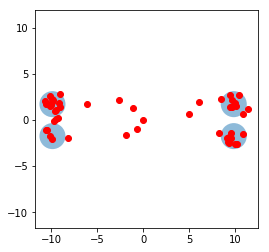

In [12]:
T_sample = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, Disp, A_true, Zs_true = generate_seq(T_sample, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Disp, mu_true, cov_true, K)

In [13]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [14]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [15]:
KLs = []
EUBOs = []
ESSs = []
optimizer.zero_grad()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()

    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Z_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, latents_dirs = naive_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Z_true, Y, T, D, K, num_particles)
    eubo.backward()
    if epoch % 10 == 0:
        optimizer.step()
        KLs.append(kl.item())
        EUBOs.append(eubo.item())
        ESSs.append(ess / num_particles)
#     log_qs.append(loss_infer.item())

        time_end = time.time()
        optimizer.zero_grad()
        print('epoch : %d, eubo : %f, KL : %f (%ds)' % (epoch, eubo, kl, time_end - time_start))
    
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -6696.062012, KL : 678.648682 (0s)
epoch : 10, eubo : -6892.649414, KL : 665.038208 (0s)
epoch : 20, eubo : -5122.983887, KL : 514.025757 (0s)
epoch : 30, eubo : -2963.208984, KL : 555.000671 (0s)
epoch : 40, eubo : -4523.312988, KL : 590.225891 (0s)
epoch : 50, eubo : -5163.217285, KL : 883.300415 (0s)


KeyboardInterrupt: 

In [ ]:
plot_dirs(latents_dirs, alpha_trans_0, Z_true, T, K, vmax=15)

In [ ]:
plot_results(EUBOs, KLs, ESSs)